# Normalizing Flows with Pytorch

This notebook was created as a exercise to implement some normalizing flow algorithms. I attended the course "Machine Learning for Graphs and Sequential Data" at the TUM and the "SimpleAffine" flow and plot function are inspiered by the course lab. 

As a continouation on the course material I have implemented the [RealNVP](https://arxiv.org/pdf/1605.08803.pdf)- transformation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import FlowDataset, plot_density
from flow_models import SimpleAffine, StackSimpleAffine, RealNVP

In [2]:
# Very simple training loop
def train(model, data, epochs = 100, batch_size = 64):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters())
    
    losses = []
    with tqdm.tqdm(range(epochs), unit=' Epoch') as tepoch:
        epoch_loss = 0
        for epoch in tepoch:
            for batch_index, training_sample in enumerate(train_loader):
                log_prob = model.log_probability(training_sample)
                loss = - log_prob.mean(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss
            epoch_loss /= len(train_loader)
            losses.append(epoch_loss.detach().numpy())
            tepoch.set_postfix(loss=epoch_loss.detach().numpy())

    return model, losses


## Toy datasets to learn with flows

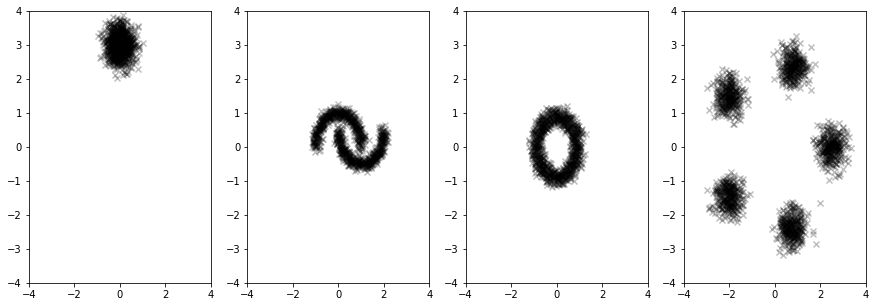

In [49]:
data_types = ['MultiVariateNormal', 'Moons', 'Circles', 'MultipleGaussians']
fig, axis = plt.subplots(1, 4, figsize=(15, 5))


for ax, name in zip(axis, data_types):
    dataset = FlowDataset(name, factor = .8, noise = .1, num_gaussians = 5)
    ax.scatter(dataset[:][:,0], dataset[:][:,1], alpha=.25, marker='x', c='black')
    ax.set(xlim=(-4, 4), ylim=(-4, 4))

## Simple Affine transform
A affine transformation is a transformation that preserves lines and parallelism (but not necessarily distances and angles). It can therefore be used to shift a given distribution.
The transforme here called SimpleAffine is defined as:

$$f(\mathbf{z})= \exp(\mathbf{a}) \odot \mathbf{z} + \mathbf{b}$$

where parameters $\mathbf{a} \in \mathbb{R}^{D}$ and $\mathbf{b} \in \mathbb{R}^{D}$. 
We apply $\exp$ elementwise to $\mathbf{a}$ to obtain positive scales for each dimension. 

The models presented are sampling from a standard multivariate normal distribution with 0 mean and unit covariance.


### Plot explanation
In the plots bellow, the orange point-clouds represent the true dataset, and the colobar corrensponds to the probability density function of our model.

100%|██████████| 500/500 [00:20<00:00, 24.31 Epoch/s, loss=0.52260906]


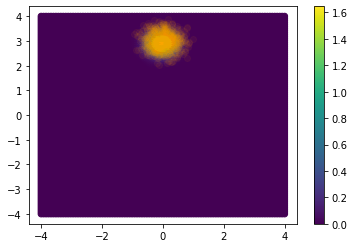

100%|██████████| 500/500 [00:21<00:00, 23.51 Epoch/s, loss=2.156036] 


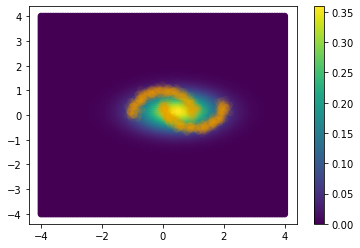

100%|██████████| 500/500 [00:19<00:00, 25.74 Epoch/s, loss=1.7922329]


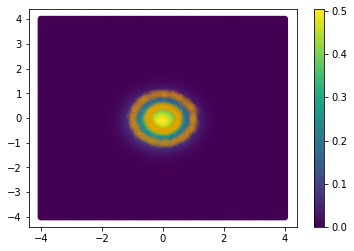

100%|██████████| 500/500 [00:19<00:00, 25.00 Epoch/s, loss=4.258012] 


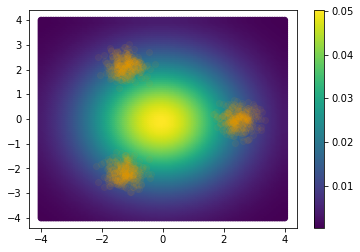

In [4]:
data_types = ['MultiVariateNormal', 'Moons', 'Circles', 'MultipleGaussians']
for name in data_types:
    data = FlowDataset(name)
    model = StackSimpleAffine([SimpleAffine()])

    model, loss = train(model, data, epochs = 500)
    plot_density(model, data)

Here we can clearly see that the simple transformation can be used to shift our mean from the center. It is also worth noting we are only using one layer, however with no non-linearities we will have a hard time capturing more complex distributions.


## RealNVP
TO be able to capture more complex distributions we turn to a more complex model. The RealNVP model was presented in 2016, and have been used for more complex tasks as image-generation. 

The strength of the model comes from the design of the transform, which simply put exploits the fact that it is very easy to compute the determinant of triangular matrices. The RealNVP transform:s Jacobian do result in a triangular jacobian, which we simply can compute the determinant of as a sum of all the elements in the diagonal. 

### Transform
Given a D-dimensional input $x$, and $d<D$, 
$$y_{1:d} = x_{1:d}$$

$$y_{d+1:D}= x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})$$

Where $s$ and $t$ are parametric functions (in our case neural networks).
Why this works so well, is because the jacobian is not dependent on $s$ or $t$, and if you do the simple calculation, you will see that calcualting the determinant will come down to summing (in log-space) the $exp(s)$-term.

This flexibillity with how we design $s$ and $t$ is one of the strengths of the RealNVP. 
Importantto note here though, is that in each step, we only updateone part of the output, the other is static. To remedy this, we alternate in each layer between which part of the output we update. In this example I will only be working with 2-d data so will alternate between the two dimensions of the data. 


100%|██████████| 500/500 [01:19<00:00,  6.26 Epoch/s, loss=1.2217777]


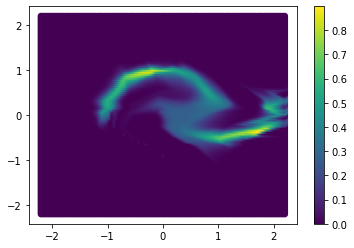

In [34]:
torch.manual_seed(2)
np.random.seed(0)

num_layers= 4
masks = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(num_layers)])).float()
hidden_size = 32

data = FlowDataset('Moons')
NVP_model = RealNVP(masks, hidden_size)
model, loss = train(NVP_model, data, epochs = 500)
plot_density(model, mesh_size=2.2)

100%|██████████| 500/500 [01:25<00:00,  5.84 Epoch/s, loss=1.2700692]


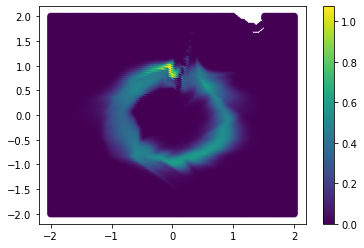

In [38]:
torch.manual_seed(8)
np.random.seed(1)

num_layers= 4
masks = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(num_layers)])).float()
hidden_size = 32

data = FlowDataset('Circles', factor = .8, noise = .1)
NVP_model = RealNVP(masks, hidden_size)
model, loss = train(NVP_model, data, epochs = 500)

plot_density(model, mesh_size=2)

100%|██████████| 500/500 [01:21<00:00,  6.10 Epoch/s, loss=2.4562032]


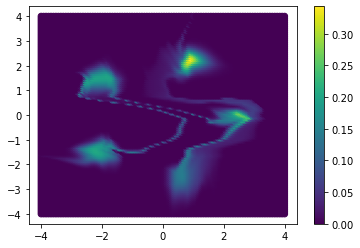

In [33]:
torch.manual_seed(8)
np.random.seed(0)

num_layers= 4
masks = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(num_layers)])).float()
hidden_size = 32

data = FlowDataset('MultipleGaussians', num_gaussians=5)
NVP_model = RealNVP(masks, hidden_size)
model, loss = train(NVP_model, data, epochs = 500)

plot_density(model)

## Conclusion
We can here very clearly see the difference between the two models. 
Here with only 4 layers of the RealNVP, can we rather exactly recreate the distributions. We can see some artefacts, and I have noticed in the runs that the models have a hard time when the different part of the distributions are too separated. 

The applications for this kind of methods are several, and one I would be interested in looking more into is anomaly detection. Maybe using these kind of networks to learn a distribution,or base-line, and then use them to detect possible errors or defects.